# 🧠 SigLIP Person Finder - Complete Google Colab Setup

This notebook provides a complete setup for the open-set person search system using natural language descriptions and a fine-tuned SigLIP model.

## What this notebook does:
1. ✅ Clone the repository
2. ✅ Install all dependencies
3. ✅ Download the dataset
4. ✅ Train the SigLIP model
5. ✅ Run inference on images
6. ✅ Visualize results

## Features:
- Text-based person search using natural language descriptions
- Multi-view ReID dataset with rich semantic attributes
- Real-time person detection with YOLOv8
- Fine-tuned SigLIP model for open-set retrieval

## 🚀 Setup and Installation

In [23]:
# Clone the repository
!git clone https://github.com/AdonaiVera/openset-reid-finetune
%cd openset-reid-finetune
print("✅ Repository cloned successfully!")

Cloning into 'openset-reid-finetune'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 78 (delta 32), reused 51 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 1.50 MiB | 29.49 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/openset-reid-finetune/openset-reid-finetune
✅ Repository cloned successfully!


In [24]:
# Install all required dependencies
!pip install -q datasets>=3.6.0 fiftyone>=1.5.2 google-generativeai>=0.8.5 \
    gradio>=5.33.0 huggingface-hub>=0.32.3 numpy>=2.2.6 pillow>=11.2.1 \
    python-dotenv>=1.1.0 sentencepiece>=0.2.0 spaces>=0.36.0 torch>=2.7.0 \
    torchvision>=0.22.0 transformers>=4.52.4 ultralytics>=8.3.148 wandb>=0.19.11 \
    tqdm opencv-python

print("✅ All dependencies installed successfully!")

✅ All dependencies installed successfully!


In [25]:
# Check GPU availability
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU detected. Training will be slower on CPU.")

CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


## 📊 Dataset Setup

In [26]:
from huggingface_hub import login

# Paste your Hugging Face token here
login("your-huggingface-token")

In [27]:
# Download the dataset from Hugging Face
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

print("📥 Downloading dataset from Hugging Face...")
dataset = load_from_hub(
    repo_id="adonaivera/fiftyone-multiview-reid-attributes",
    dataset_name="fiftyone-multiview-reid2",
    overwrite=True
)

print(f"✅ Dataset loaded successfully!")
print(f"📊 Total samples: {len(dataset)}")
print(f"🏷️ Tags: {dataset.count_values('tags')}")

# Show a sample
sample = dataset.first()
print(f"\n📸 Sample image: {sample.filepath}")
print(f"👤 Person ID: {sample.person_id}")
print(f"📝 Description: {sample.description}")
if sample.attributes:
    print(f"🏷️ Attributes: {sample.attributes}")

📥 Downloading dataset from Hugging Face...


INFO:fiftyone.utils.huggingface:Downloading config file fiftyone.yml from adonaivera/fiftyone-multiview-reid-attributes


Loading dataset


INFO:fiftyone.utils.huggingface:Loading dataset


Importing samples...


INFO:fiftyone.utils.data.importers:Importing samples...


 100% |███████████████| 6455/6455 [668.7ms elapsed, 0s remaining, 9.8K samples/s]       


INFO:eta.core.utils: 100% |███████████████| 6455/6455 [668.7ms elapsed, 0s remaining, 9.8K samples/s]       


✅ Dataset loaded successfully!
📊 Total samples: 6455
🏷️ Tags: {'train': 3181, 'query': 3269, 'gallery': 5}

📸 Sample image: /root/fiftyone/huggingface/hub/adonaivera/fiftyone-multiview-reid-attributes/data/00000002_01.jpg
👤 Person ID: 2
📝 Description: The person is a male adult wearing a red t-shirt, blue denim shorts, and dark sandals. He has short, dark hair and is walking.
🏷️ Attributes: {'gender': 'Male', 'age': 'Adult', 'ethnicity': 'Unknown', 'occupation': 'Unknown', 'appearance': {'hair': {'type': 'Short', 'color': 'Black', 'description': 'Short, dark hair.'}, 'beard': {'type': 'None', 'color': 'Unknown', 'description': 'No beard visible.'}, 'expression': {'type': 'Unknown', 'description': 'Facial expression is not clearly visible.'}}, 'posture': {'type': 'Walking', 'description': 'The person is walking.'}, 'actions': {'type': 'Walking', 'description': 'The person is walking.'}, 'clothing': {'upper': {'type': 'T-shirt', 'color': 'Red', 'description': 'A red t-shirt with a logo.'

📸 Training samples:


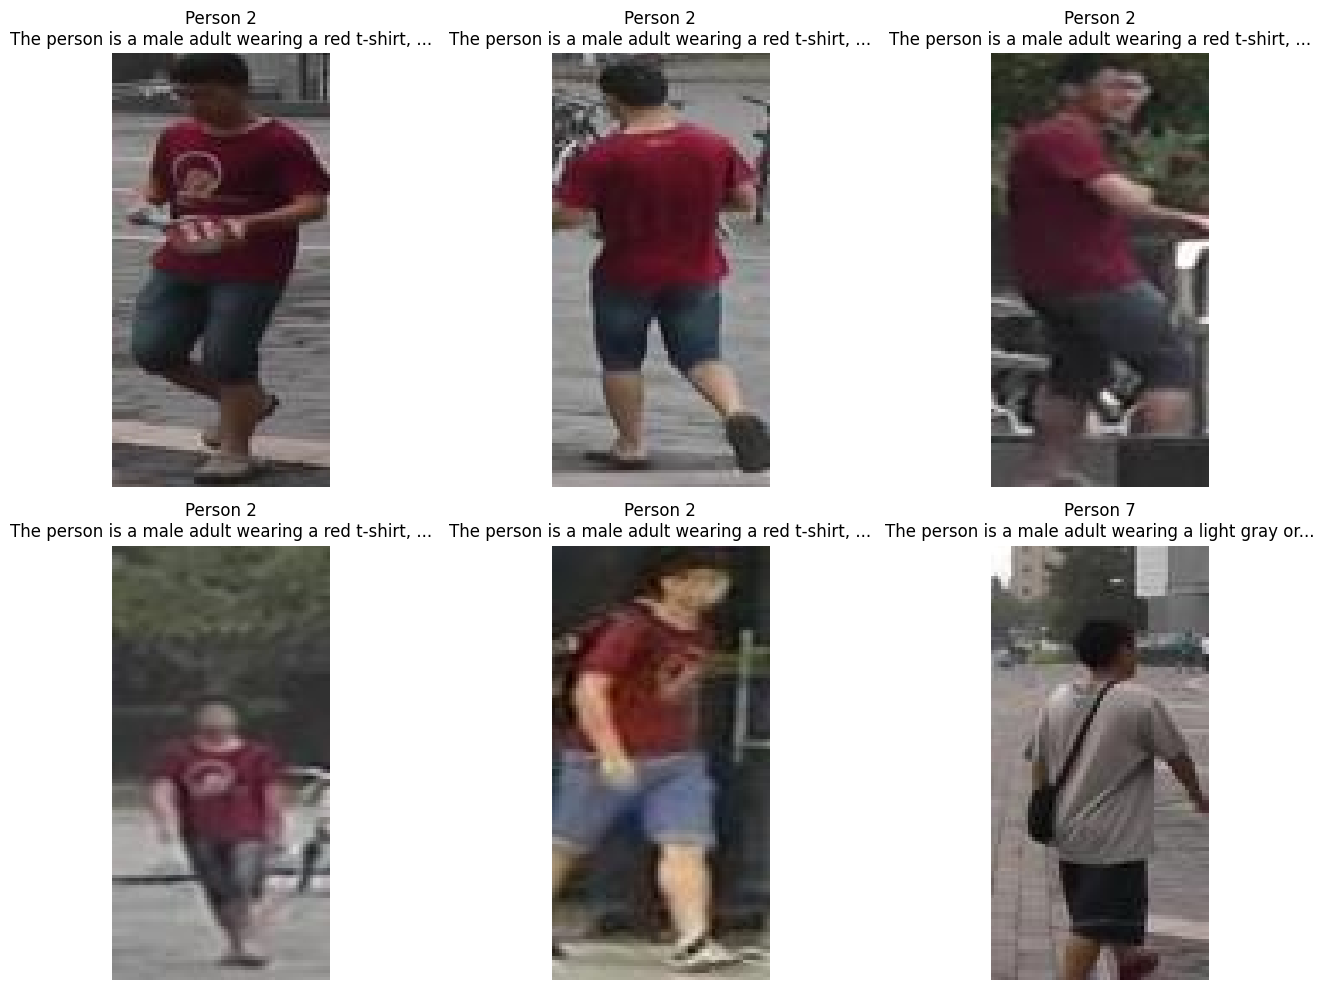

🔍 Query samples:


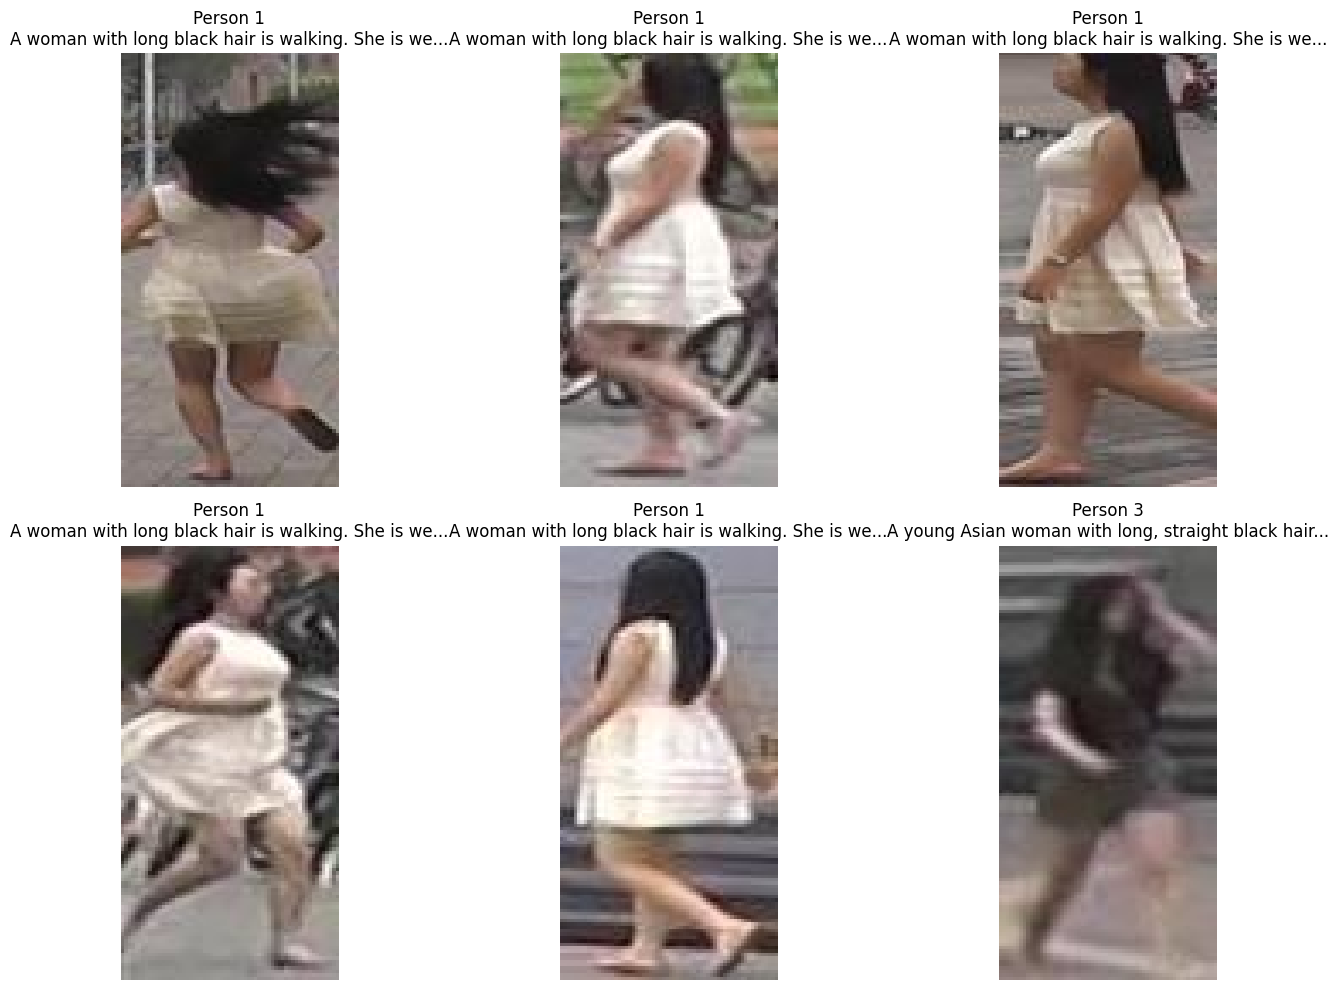

In [28]:
# Visualize some samples from the dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    samples = dataset.limit(num_samples)

    for i, sample in enumerate(samples):
        img = Image.open(sample.filepath)
        axes[i].imshow(img)
        axes[i].set_title(f"Person {sample.person_id}\n{sample.description[:50]}...")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Show training samples
print("📸 Training samples:")
train_samples = dataset.match_tags("train")
show_samples(train_samples)

# Show query samples
print("🔍 Query samples:")
query_samples = dataset.match_tags("query")
show_samples(query_samples)

## 🧠 Model Training

In [29]:
# Import training modules
import sys
sys.path.append('.')

from utils.datasets import TextImageDataset, load_dataset
from utils.collators import TextImageCollator
from transformers import AutoProcessor, SiglipModel, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os

print("✅ Training modules imported successfully!")

✅ Training modules imported successfully!


In [30]:
# Training configuration
class TrainingConfig:
    def __init__(self):
        self.epochs = 5  # Reduced for Colab demo
        self.batch_size = 8  # Reduced for Colab memory
        self.lr = 1e-5
        self.save_dir = "models"
        self.patience = 3
        self.temperature = 0.07

config = TrainingConfig()
print(f"⚙️ Training config:")
print(f"   Epochs: {config.epochs}")
print(f"   Batch size: {config.batch_size}")
print(f"   Learning rate: {config.lr}")
print(f"   Save directory: {config.save_dir}")

⚙️ Training config:
   Epochs: 5
   Batch size: 8
   Learning rate: 1e-05
   Save directory: models


In [31]:
# Prepare dataloaders
print("📊 Preparing dataloaders...")

# Load model and processor
model = SiglipModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create datasets
train_ds = TextImageDataset(dataset, split="train", processor=processor, augment=True)
val_ds = TextImageDataset(dataset, split="query", processor=processor, augment=False)

# Create dataloaders
train_dl = DataLoader(
    train_ds,
    batch_size=config.batch_size,
    shuffle=True,
    collate_fn=TextImageCollator(processor),
    num_workers=2,  # Reduced for Colab
)

val_dl = DataLoader(
    val_ds,
    batch_size=config.batch_size,
    shuffle=False,
    collate_fn=TextImageCollator(processor),
    num_workers=2,  # Reduced for Colab
)

print(f"✅ Dataloaders created!")
print(f"   Training batches: {len(train_dl)}")
print(f"   Validation batches: {len(val_dl)}")

📊 Preparing dataloaders...
✅ Dataloaders created!
   Training batches: 398
   Validation batches: 409


In [32]:
# Training loop
print("🚀 Starting training...")

# Create save directory
os.makedirs(config.save_dir, exist_ok=True)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=config.lr, weight_decay=0.01)
num_training_steps = config.epochs * len(train_dl)
scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=50, num_training_steps=num_training_steps)

# Training history
train_losses = []
val_scores = []
best_loss = float("inf")
no_improve_epochs = 0

for epoch in range(config.epochs):
    print(f"\n📈 Epoch {epoch + 1}/{config.epochs}")

    # Training phase
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dl, desc="Training")):
        batch = {k: v.to(device) for k, v in batch.items() if torch.is_tensor(v)}

        image_features = model.get_image_features(pixel_values=batch['pixel_values'])
        text_features = model.get_text_features(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        logits_per_image = torch.matmul(image_features, text_features.T) / config.temperature
        labels = torch.arange(len(image_features), device=device)

        loss = (F.cross_entropy(logits_per_image, labels) + F.cross_entropy(logits_per_image.T, labels)) / 2
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()

        total_loss += loss.item()

        if step % 10 == 0:
            print(f"   Step {step} | Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dl)
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()
    all_image_feats = []
    all_text_feats = []

    with torch.no_grad():
        for batch in tqdm(val_dl, desc="Validation"):
            batch = {k: v.to(device) for k, v in batch.items() if torch.is_tensor(v)}

            image_feats = model.get_image_features(batch['pixel_values'])
            text_feats = model.get_text_features(batch['input_ids'], batch['attention_mask'])

            image_feats = F.normalize(image_feats, dim=-1)
            text_feats = F.normalize(text_feats, dim=-1)

            all_image_feats.append(image_feats)
            all_text_feats.append(text_feats)

        image_feats = torch.cat(all_image_feats, dim=0)
        text_feats = torch.cat(all_text_feats, dim=0)

        similarity_matrix = image_feats @ text_feats.T
        target = torch.arange(similarity_matrix.size(0)).to(device)

        # Image-to-text retrieval
        top1 = similarity_matrix.topk(1, dim=1).indices.squeeze()
        recall_at_1 = (top1 == target).float().mean().item()

        top5 = similarity_matrix.topk(5, dim=1).indices
        recall_at_5 = (top5 == target.unsqueeze(1)).any(dim=1).float().mean().item()

        val_score = recall_at_5
        val_scores.append(val_score)

    print(f"📊 Epoch {epoch + 1} | Train Loss: {avg_loss:.4f} | Val Recall@1: {recall_at_1:.4f} | Val Recall@5: {recall_at_5:.4f}")

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve_epochs = 0
        best_path = os.path.join(config.save_dir, f"best_model_epoch_{epoch + 1}_loss_{avg_loss:.4f}.pt")
        torch.save(model.state_dict(), best_path)
        print(f"✅ New best model saved to {best_path}")
    else:
        no_improve_epochs += 1
        print(f"⚠️ No improvement. Patience counter: {no_improve_epochs}/{config.patience}")

    if no_improve_epochs >= config.patience:
        print("🛑 Early stopping triggered.")
        break

print("🎉 Training completed!")

🚀 Starting training...

📈 Epoch 1/5


Training:   0%|          | 1/398 [00:05<34:49,  5.26s/it]

   Step 0 | Loss: 2.0579


Training:   3%|▎         | 11/398 [00:20<15:02,  2.33s/it]

   Step 10 | Loss: 2.1789


Training:   5%|▌         | 21/398 [00:29<06:47,  1.08s/it]

   Step 20 | Loss: 1.8421


Training:   8%|▊         | 31/398 [00:43<08:36,  1.41s/it]

   Step 30 | Loss: 1.5637


Training:  10%|█         | 41/398 [00:56<05:49,  1.02it/s]

   Step 40 | Loss: 1.9778


Training:  13%|█▎        | 51/398 [01:04<05:18,  1.09it/s]

   Step 50 | Loss: 1.3207


Training:  15%|█▌        | 61/398 [01:13<03:54,  1.44it/s]

   Step 60 | Loss: 1.3728


Training:  18%|█▊        | 71/398 [01:22<04:54,  1.11it/s]

   Step 70 | Loss: 1.7114


Training:  20%|██        | 81/398 [01:30<05:28,  1.03s/it]

   Step 80 | Loss: 0.6797


Training:  23%|██▎       | 91/398 [01:41<04:01,  1.27it/s]

   Step 90 | Loss: 0.7944


Training:  25%|██▌       | 101/398 [01:49<04:00,  1.24it/s]

   Step 100 | Loss: 0.9403


Training:  28%|██▊       | 111/398 [01:55<03:05,  1.55it/s]

   Step 110 | Loss: 1.2409


Training:  30%|███       | 121/398 [02:03<03:25,  1.35it/s]

   Step 120 | Loss: 0.7717


Training:  33%|███▎      | 131/398 [02:09<02:31,  1.76it/s]

   Step 130 | Loss: 0.3691


Training:  35%|███▌      | 141/398 [02:18<04:09,  1.03it/s]

   Step 140 | Loss: 0.9323


Training:  38%|███▊      | 151/398 [02:28<04:51,  1.18s/it]

   Step 150 | Loss: 0.7219


Training:  40%|████      | 161/398 [02:35<02:24,  1.64it/s]

   Step 160 | Loss: 0.9411


Training:  43%|████▎     | 171/398 [02:41<02:35,  1.46it/s]

   Step 170 | Loss: 1.1921


Training:  45%|████▌     | 181/398 [02:50<02:54,  1.24it/s]

   Step 180 | Loss: 0.8600


Training:  48%|████▊     | 191/398 [02:59<03:20,  1.03it/s]

   Step 190 | Loss: 0.6205


Training:  51%|█████     | 201/398 [03:04<01:50,  1.79it/s]

   Step 200 | Loss: 0.9889


Training:  53%|█████▎    | 211/398 [03:12<03:12,  1.03s/it]

   Step 210 | Loss: 0.5211


Training:  56%|█████▌    | 221/398 [03:29<04:11,  1.42s/it]

   Step 220 | Loss: 0.4471


Training:  58%|█████▊    | 231/398 [03:35<01:44,  1.60it/s]

   Step 230 | Loss: 0.6116


Training:  61%|██████    | 241/398 [03:43<02:01,  1.29it/s]

   Step 240 | Loss: 0.5746


Training:  63%|██████▎   | 251/398 [03:50<01:34,  1.55it/s]

   Step 250 | Loss: 0.4483


Training:  66%|██████▌   | 261/398 [04:00<01:47,  1.28it/s]

   Step 260 | Loss: 0.2358


Training:  68%|██████▊   | 271/398 [04:07<01:42,  1.25it/s]

   Step 270 | Loss: 0.9059


Training:  71%|███████   | 281/398 [04:15<01:17,  1.51it/s]

   Step 280 | Loss: 0.8059


Training:  73%|███████▎  | 291/398 [04:22<01:14,  1.43it/s]

   Step 290 | Loss: 0.6440


Training:  76%|███████▌  | 301/398 [04:29<00:53,  1.80it/s]

   Step 300 | Loss: 0.3076


Training:  78%|███████▊  | 311/398 [04:39<01:41,  1.16s/it]

   Step 310 | Loss: 0.4452


Training:  81%|████████  | 321/398 [04:47<01:06,  1.16it/s]

   Step 320 | Loss: 0.6360


Training:  83%|████████▎ | 331/398 [04:55<01:00,  1.12it/s]

   Step 330 | Loss: 0.4647


Training:  86%|████████▌ | 341/398 [05:01<00:31,  1.78it/s]

   Step 340 | Loss: 0.3100


Training:  88%|████████▊ | 351/398 [05:10<00:37,  1.25it/s]

   Step 350 | Loss: 0.3849


Training:  91%|█████████ | 361/398 [05:18<00:33,  1.09it/s]

   Step 360 | Loss: 0.4339


Training:  93%|█████████▎| 371/398 [05:26<00:18,  1.43it/s]

   Step 370 | Loss: 0.4743


Training:  96%|█████████▌| 381/398 [05:32<00:10,  1.64it/s]

   Step 380 | Loss: 0.2574


Training:  98%|█████████▊| 391/398 [05:40<00:04,  1.50it/s]

   Step 390 | Loss: 0.4021


Validation: 100%|██████████| 409/409 [00:46<00:00,  8.81it/s]


📊 Epoch 1 | Train Loss: 0.8309 | Val Recall@1: 0.0480 | Val Recall@5: 0.1979
✅ New best model saved to models/best_model_epoch_1_loss_0.8309.pt

📈 Epoch 2/5


Training:   0%|          | 1/398 [00:01<11:17,  1.71s/it]

   Step 0 | Loss: 0.5047


Training:   3%|▎         | 11/398 [00:08<04:00,  1.61it/s]

   Step 10 | Loss: 0.3020


Training:   5%|▌         | 21/398 [00:16<04:32,  1.39it/s]

   Step 20 | Loss: 0.3932


Training:   8%|▊         | 31/398 [00:23<03:58,  1.54it/s]

   Step 30 | Loss: 0.2509


Training:  10%|█         | 41/398 [00:33<04:45,  1.25it/s]

   Step 40 | Loss: 0.3339


Training:  13%|█▎        | 51/398 [00:40<04:27,  1.30it/s]

   Step 50 | Loss: 0.7642


Training:  15%|█▌        | 61/398 [00:47<03:19,  1.69it/s]

   Step 60 | Loss: 0.2399


Training:  18%|█▊        | 71/398 [00:52<02:54,  1.87it/s]

   Step 70 | Loss: 0.2375


Training:  20%|██        | 81/398 [01:00<03:21,  1.57it/s]

   Step 80 | Loss: 0.3149


Training:  23%|██▎       | 91/398 [01:06<03:11,  1.60it/s]

   Step 90 | Loss: 0.5759


Training:  25%|██▌       | 101/398 [01:15<03:56,  1.26it/s]

   Step 100 | Loss: 0.5251


Training:  28%|██▊       | 111/398 [01:20<02:44,  1.75it/s]

   Step 110 | Loss: 0.2006


Training:  30%|███       | 121/398 [01:28<03:23,  1.36it/s]

   Step 120 | Loss: 0.1317


Training:  33%|███▎      | 131/398 [01:35<02:58,  1.50it/s]

   Step 130 | Loss: 0.2868


Training:  35%|███▌      | 141/398 [01:43<02:53,  1.49it/s]

   Step 140 | Loss: 0.6524


Training:  38%|███▊      | 151/398 [01:50<02:50,  1.45it/s]

   Step 150 | Loss: 0.6328


Training:  40%|████      | 161/398 [01:59<03:02,  1.30it/s]

   Step 160 | Loss: 0.1221


Training:  43%|████▎     | 171/398 [02:05<02:29,  1.52it/s]

   Step 170 | Loss: 0.0994


Training:  45%|████▌     | 181/398 [02:12<02:11,  1.65it/s]

   Step 180 | Loss: 0.2003


Training:  48%|████▊     | 191/398 [02:19<02:28,  1.40it/s]

   Step 190 | Loss: 0.3232


Training:  51%|█████     | 201/398 [02:28<02:04,  1.58it/s]

   Step 200 | Loss: 0.1638


Training:  53%|█████▎    | 211/398 [02:37<02:32,  1.23it/s]

   Step 210 | Loss: 0.2332


Training:  56%|█████▌    | 221/398 [02:44<01:42,  1.72it/s]

   Step 220 | Loss: 0.4192


Training:  58%|█████▊    | 231/398 [02:52<02:35,  1.07it/s]

   Step 230 | Loss: 0.3261


Training:  61%|██████    | 241/398 [03:00<02:07,  1.24it/s]

   Step 240 | Loss: 0.2958


Training:  63%|██████▎   | 251/398 [03:08<01:58,  1.24it/s]

   Step 250 | Loss: 0.0842


Training:  66%|██████▌   | 261/398 [03:16<01:44,  1.31it/s]

   Step 260 | Loss: 0.0995


Training:  68%|██████▊   | 271/398 [03:23<01:33,  1.36it/s]

   Step 270 | Loss: 0.6304


Training:  71%|███████   | 281/398 [03:30<01:14,  1.58it/s]

   Step 280 | Loss: 0.1350


Training:  73%|███████▎  | 291/398 [03:37<01:17,  1.39it/s]

   Step 290 | Loss: 0.0985


Training:  76%|███████▌  | 301/398 [03:45<01:16,  1.27it/s]

   Step 300 | Loss: 0.3328


Training:  78%|███████▊  | 311/398 [03:53<00:57,  1.50it/s]

   Step 310 | Loss: 0.1943


Training:  81%|████████  | 321/398 [03:59<00:42,  1.79it/s]

   Step 320 | Loss: 0.1400


Training:  83%|████████▎ | 331/398 [04:07<00:47,  1.40it/s]

   Step 330 | Loss: 0.1221


Training:  86%|████████▌ | 341/398 [04:13<00:33,  1.71it/s]

   Step 340 | Loss: 0.0508


Training:  88%|████████▊ | 351/398 [04:21<00:35,  1.33it/s]

   Step 350 | Loss: 0.1457


Training:  91%|█████████ | 361/398 [04:27<00:21,  1.72it/s]

   Step 360 | Loss: 0.2363


Training:  93%|█████████▎| 371/398 [04:35<00:20,  1.29it/s]

   Step 370 | Loss: 0.2523


Training:  96%|█████████▌| 381/398 [04:42<00:15,  1.13it/s]

   Step 380 | Loss: 0.2173


Training:  98%|█████████▊| 391/398 [04:51<00:04,  1.50it/s]

   Step 390 | Loss: 0.3155


Validation: 100%|██████████| 409/409 [00:44<00:00,  9.20it/s]


📊 Epoch 2 | Train Loss: 0.3233 | Val Recall@1: 0.0486 | Val Recall@5: 0.2181
✅ New best model saved to models/best_model_epoch_2_loss_0.3233.pt

📈 Epoch 3/5


Training:   0%|          | 1/398 [00:02<19:40,  2.97s/it]

   Step 0 | Loss: 0.6979


Training:   3%|▎         | 11/398 [00:10<04:54,  1.31it/s]

   Step 10 | Loss: 0.1398


Training:   5%|▌         | 21/398 [00:17<04:21,  1.44it/s]

   Step 20 | Loss: 0.2277


Training:   8%|▊         | 31/398 [00:23<04:41,  1.31it/s]

   Step 30 | Loss: 0.5419


Training:  10%|█         | 41/398 [00:32<07:08,  1.20s/it]

   Step 40 | Loss: 0.0351


Training:  13%|█▎        | 51/398 [00:39<03:51,  1.50it/s]

   Step 50 | Loss: 0.1980


Training:  15%|█▌        | 61/398 [00:46<05:06,  1.10it/s]

   Step 60 | Loss: 0.1481


Training:  18%|█▊        | 71/398 [00:53<03:50,  1.42it/s]

   Step 70 | Loss: 0.2430


Training:  20%|██        | 81/398 [01:00<04:42,  1.12it/s]

   Step 80 | Loss: 0.0634


Training:  23%|██▎       | 91/398 [01:07<03:15,  1.57it/s]

   Step 90 | Loss: 0.0693


Training:  25%|██▌       | 101/398 [01:15<04:50,  1.02it/s]

   Step 100 | Loss: 0.0092


Training:  28%|██▊       | 111/398 [01:23<03:23,  1.41it/s]

   Step 110 | Loss: 0.1446


Training:  30%|███       | 121/398 [01:32<03:40,  1.25it/s]

   Step 120 | Loss: 0.2288


Training:  33%|███▎      | 131/398 [01:38<03:00,  1.48it/s]

   Step 130 | Loss: 0.2536


Training:  35%|███▌      | 141/398 [01:47<03:19,  1.29it/s]

   Step 140 | Loss: 0.2259


Training:  38%|███▊      | 151/398 [01:53<03:01,  1.36it/s]

   Step 150 | Loss: 0.0970


Training:  40%|████      | 161/398 [02:01<02:43,  1.45it/s]

   Step 160 | Loss: 0.2763


Training:  43%|████▎     | 171/398 [02:08<02:51,  1.32it/s]

   Step 170 | Loss: 0.1103


Training:  45%|████▌     | 181/398 [02:17<02:32,  1.42it/s]

   Step 180 | Loss: 0.1832


Training:  48%|████▊     | 191/398 [02:22<02:04,  1.66it/s]

   Step 190 | Loss: 0.1640


Training:  51%|█████     | 201/398 [02:31<02:12,  1.49it/s]

   Step 200 | Loss: 0.1079


Training:  53%|█████▎    | 211/398 [02:39<02:38,  1.18it/s]

   Step 210 | Loss: 0.1307


Training:  56%|█████▌    | 221/398 [02:47<02:28,  1.19it/s]

   Step 220 | Loss: 0.0404


Training:  58%|█████▊    | 231/398 [02:55<03:06,  1.12s/it]

   Step 230 | Loss: 0.1160


Training:  61%|██████    | 241/398 [03:01<01:37,  1.61it/s]

   Step 240 | Loss: 0.1916


Training:  63%|██████▎   | 251/398 [03:10<02:43,  1.11s/it]

   Step 250 | Loss: 0.5102


Training:  66%|██████▌   | 261/398 [03:17<01:26,  1.59it/s]

   Step 260 | Loss: 0.4686


Training:  68%|██████▊   | 271/398 [03:25<02:01,  1.05it/s]

   Step 270 | Loss: 0.1454


Training:  71%|███████   | 281/398 [03:32<01:21,  1.43it/s]

   Step 280 | Loss: 0.2213


Training:  73%|███████▎  | 291/398 [03:39<01:18,  1.37it/s]

   Step 290 | Loss: 0.0469


Training:  76%|███████▌  | 301/398 [03:46<01:00,  1.60it/s]

   Step 300 | Loss: 0.0056


Training:  78%|███████▊  | 311/398 [03:54<01:08,  1.28it/s]

   Step 310 | Loss: 0.2038


Training:  81%|████████  | 321/398 [04:01<00:45,  1.68it/s]

   Step 320 | Loss: 0.0729


Training:  83%|████████▎ | 331/398 [04:08<00:47,  1.41it/s]

   Step 330 | Loss: 0.0297


Training:  86%|████████▌ | 341/398 [04:15<00:37,  1.54it/s]

   Step 340 | Loss: 0.1948


Training:  88%|████████▊ | 351/398 [04:24<00:33,  1.40it/s]

   Step 350 | Loss: 0.1659


Training:  91%|█████████ | 361/398 [04:31<00:32,  1.12it/s]

   Step 360 | Loss: 0.0538


Training:  93%|█████████▎| 371/398 [04:39<00:18,  1.48it/s]

   Step 370 | Loss: 0.3867


Training:  96%|█████████▌| 381/398 [04:44<00:09,  1.85it/s]

   Step 380 | Loss: 0.0247


Training:  98%|█████████▊| 391/398 [04:53<00:06,  1.10it/s]

   Step 390 | Loss: 0.0374


Validation: 100%|██████████| 409/409 [00:44<00:00,  9.21it/s]


📊 Epoch 3 | Train Loss: 0.1932 | Val Recall@1: 0.0489 | Val Recall@5: 0.2276
✅ New best model saved to models/best_model_epoch_3_loss_0.1932.pt

📈 Epoch 4/5


Training:   0%|          | 1/398 [00:02<16:36,  2.51s/it]

   Step 0 | Loss: 0.0684


Training:   3%|▎         | 11/398 [00:09<04:20,  1.49it/s]

   Step 10 | Loss: 0.0458


Training:   5%|▌         | 21/398 [00:16<03:51,  1.63it/s]

   Step 20 | Loss: 0.0298


Training:   8%|▊         | 31/398 [00:22<03:31,  1.74it/s]

   Step 30 | Loss: 0.1039


Training:  10%|█         | 41/398 [00:28<03:22,  1.77it/s]

   Step 40 | Loss: 0.2234


Training:  13%|█▎        | 51/398 [00:36<04:54,  1.18it/s]

   Step 50 | Loss: 0.1713


Training:  15%|█▌        | 61/398 [00:44<04:12,  1.34it/s]

   Step 60 | Loss: 0.1568


Training:  18%|█▊        | 71/398 [00:52<04:17,  1.27it/s]

   Step 70 | Loss: 0.1887


Training:  20%|██        | 81/398 [00:59<03:17,  1.61it/s]

   Step 80 | Loss: 0.0746


Training:  23%|██▎       | 91/398 [01:07<03:36,  1.42it/s]

   Step 90 | Loss: 0.1818


Training:  25%|██▌       | 101/398 [01:14<03:20,  1.48it/s]

   Step 100 | Loss: 0.0296


Training:  28%|██▊       | 111/398 [01:22<03:01,  1.58it/s]

   Step 110 | Loss: 0.0296


Training:  30%|███       | 121/398 [01:28<02:38,  1.74it/s]

   Step 120 | Loss: 0.0326


Training:  33%|███▎      | 131/398 [01:37<03:15,  1.37it/s]

   Step 130 | Loss: 0.0615


Training:  35%|███▌      | 141/398 [01:44<03:16,  1.31it/s]

   Step 140 | Loss: 0.0125


Training:  38%|███▊      | 151/398 [01:52<02:46,  1.49it/s]

   Step 150 | Loss: 0.0382


Training:  40%|████      | 161/398 [02:01<04:42,  1.19s/it]

   Step 160 | Loss: 0.2004


Training:  43%|████▎     | 171/398 [02:09<03:36,  1.05it/s]

   Step 170 | Loss: 0.1298


Training:  45%|████▌     | 181/398 [02:17<02:41,  1.34it/s]

   Step 180 | Loss: 0.0781


Training:  48%|████▊     | 191/398 [02:24<02:42,  1.28it/s]

   Step 190 | Loss: 0.0489


Training:  51%|█████     | 201/398 [02:32<02:43,  1.20it/s]

   Step 200 | Loss: 0.0895


Training:  53%|█████▎    | 211/398 [02:38<01:57,  1.60it/s]

   Step 210 | Loss: 0.0784


Training:  56%|█████▌    | 221/398 [02:46<02:40,  1.10it/s]

   Step 220 | Loss: 0.2785


Training:  58%|█████▊    | 231/398 [02:53<02:00,  1.38it/s]

   Step 230 | Loss: 0.1599


Training:  61%|██████    | 241/398 [03:02<02:39,  1.02s/it]

   Step 240 | Loss: 0.4469


Training:  63%|██████▎   | 251/398 [03:08<01:33,  1.57it/s]

   Step 250 | Loss: 0.0200


Training:  66%|██████▌   | 261/398 [03:17<01:34,  1.45it/s]

   Step 260 | Loss: 0.6223


Training:  68%|██████▊   | 271/398 [03:24<01:24,  1.50it/s]

   Step 270 | Loss: 0.1443


Training:  71%|███████   | 281/398 [03:32<01:14,  1.58it/s]

   Step 280 | Loss: 0.7990


Training:  73%|███████▎  | 291/398 [03:38<01:12,  1.48it/s]

   Step 290 | Loss: 0.0312


Training:  76%|███████▌  | 301/398 [03:46<01:02,  1.55it/s]

   Step 300 | Loss: 0.0049


Training:  78%|███████▊  | 311/398 [03:52<00:55,  1.56it/s]

   Step 310 | Loss: 0.0090


Training:  81%|████████  | 321/398 [04:01<00:59,  1.30it/s]

   Step 320 | Loss: 0.0426


Training:  83%|████████▎ | 331/398 [04:08<00:48,  1.39it/s]

   Step 330 | Loss: 0.0126


Training:  86%|████████▌ | 341/398 [04:15<00:34,  1.66it/s]

   Step 340 | Loss: 0.0656


Training:  88%|████████▊ | 351/398 [04:22<00:35,  1.33it/s]

   Step 350 | Loss: 0.3690


Training:  91%|█████████ | 361/398 [04:30<00:24,  1.49it/s]

   Step 360 | Loss: 0.1093


Training:  93%|█████████▎| 371/398 [04:36<00:16,  1.66it/s]

   Step 370 | Loss: 0.0431


Training:  96%|█████████▌| 381/398 [04:46<00:11,  1.47it/s]

   Step 380 | Loss: 0.0482


Training:  98%|█████████▊| 391/398 [04:54<00:07,  1.13s/it]

   Step 390 | Loss: 0.2798


Validation: 100%|██████████| 409/409 [00:44<00:00,  9.19it/s]


📊 Epoch 4 | Train Loss: 0.1093 | Val Recall@1: 0.0584 | Val Recall@5: 0.2631
✅ New best model saved to models/best_model_epoch_4_loss_0.1093.pt

📈 Epoch 5/5


Training:   0%|          | 1/398 [00:01<08:43,  1.32s/it]

   Step 0 | Loss: 0.1236


Training:   3%|▎         | 11/398 [00:10<04:53,  1.32it/s]

   Step 10 | Loss: 0.1910


Training:   5%|▌         | 21/398 [00:16<03:19,  1.89it/s]

   Step 20 | Loss: 0.1069


Training:   8%|▊         | 31/398 [00:24<05:37,  1.09it/s]

   Step 30 | Loss: 0.1530


Training:  10%|█         | 41/398 [00:31<04:38,  1.28it/s]

   Step 40 | Loss: 0.0380


Training:  13%|█▎        | 51/398 [00:40<05:01,  1.15it/s]

   Step 50 | Loss: 0.2623


Training:  15%|█▌        | 61/398 [00:46<03:49,  1.47it/s]

   Step 60 | Loss: 0.0834


Training:  18%|█▊        | 71/398 [00:55<03:45,  1.45it/s]

   Step 70 | Loss: 0.0072


Training:  20%|██        | 81/398 [01:03<05:11,  1.02it/s]

   Step 80 | Loss: 0.0077


Training:  23%|██▎       | 91/398 [01:10<03:13,  1.59it/s]

   Step 90 | Loss: 0.0088


Training:  25%|██▌       | 101/398 [01:18<03:27,  1.43it/s]

   Step 100 | Loss: 0.0163


Training:  28%|██▊       | 111/398 [01:26<03:59,  1.20it/s]

   Step 110 | Loss: 0.2835


Training:  30%|███       | 121/398 [01:33<04:17,  1.08it/s]

   Step 120 | Loss: 0.0562


Training:  33%|███▎      | 131/398 [01:41<02:54,  1.53it/s]

   Step 130 | Loss: 0.0396


Training:  35%|███▌      | 141/398 [01:48<03:54,  1.10it/s]

   Step 140 | Loss: 0.3232


Training:  38%|███▊      | 151/398 [01:55<02:36,  1.58it/s]

   Step 150 | Loss: 0.0492


Training:  40%|████      | 161/398 [02:02<03:07,  1.27it/s]

   Step 160 | Loss: 0.0151


Training:  43%|████▎     | 171/398 [02:09<02:19,  1.62it/s]

   Step 170 | Loss: 0.0180


Training:  45%|████▌     | 181/398 [02:17<03:12,  1.13it/s]

   Step 180 | Loss: 0.1138


Training:  48%|████▊     | 191/398 [02:24<02:03,  1.67it/s]

   Step 190 | Loss: 0.0746


Training:  51%|█████     | 201/398 [02:32<03:08,  1.05it/s]

   Step 200 | Loss: 0.0296


Training:  53%|█████▎    | 211/398 [02:39<02:08,  1.46it/s]

   Step 210 | Loss: 0.0253


Training:  56%|█████▌    | 221/398 [02:48<02:47,  1.06it/s]

   Step 220 | Loss: 0.0144


Training:  58%|█████▊    | 231/398 [02:55<02:29,  1.11it/s]

   Step 230 | Loss: 0.1718


Training:  61%|██████    | 241/398 [03:04<02:09,  1.22it/s]

   Step 240 | Loss: 0.0378


Training:  63%|██████▎   | 251/398 [03:10<01:32,  1.59it/s]

   Step 250 | Loss: 0.0405


Training:  66%|██████▌   | 261/398 [03:19<01:43,  1.33it/s]

   Step 260 | Loss: 0.0052


Training:  68%|██████▊   | 271/398 [03:25<01:16,  1.66it/s]

   Step 270 | Loss: 0.0240


Training:  71%|███████   | 281/398 [03:33<01:22,  1.43it/s]

   Step 280 | Loss: 0.1869


Training:  73%|███████▎  | 291/398 [03:39<01:01,  1.73it/s]

   Step 290 | Loss: 0.0221


Training:  76%|███████▌  | 301/398 [03:47<01:08,  1.41it/s]

   Step 300 | Loss: 0.0525


Training:  78%|███████▊  | 311/398 [03:53<00:53,  1.61it/s]

   Step 310 | Loss: 0.1097


Training:  81%|████████  | 321/398 [04:03<00:59,  1.29it/s]

   Step 320 | Loss: 0.2289


Training:  83%|████████▎ | 331/398 [04:12<01:03,  1.06it/s]

   Step 330 | Loss: 0.0482


Training:  86%|████████▌ | 341/398 [04:19<00:48,  1.18it/s]

   Step 340 | Loss: 0.1975


Training:  88%|████████▊ | 351/398 [04:28<00:44,  1.07it/s]

   Step 350 | Loss: 0.1143


Training:  91%|█████████ | 361/398 [04:34<00:23,  1.57it/s]

   Step 360 | Loss: 0.0755


Training:  93%|█████████▎| 371/398 [04:43<00:20,  1.34it/s]

   Step 370 | Loss: 0.0680


Training:  96%|█████████▌| 381/398 [04:50<00:10,  1.64it/s]

   Step 380 | Loss: 0.0182


Training:  98%|█████████▊| 391/398 [04:59<00:05,  1.33it/s]

   Step 390 | Loss: 0.1751


Validation: 100%|██████████| 409/409 [00:44<00:00,  9.19it/s]


📊 Epoch 5 | Train Loss: 0.0978 | Val Recall@1: 0.0627 | Val Recall@5: 0.2637
✅ New best model saved to models/best_model_epoch_5_loss_0.0978.pt
🎉 Training completed!


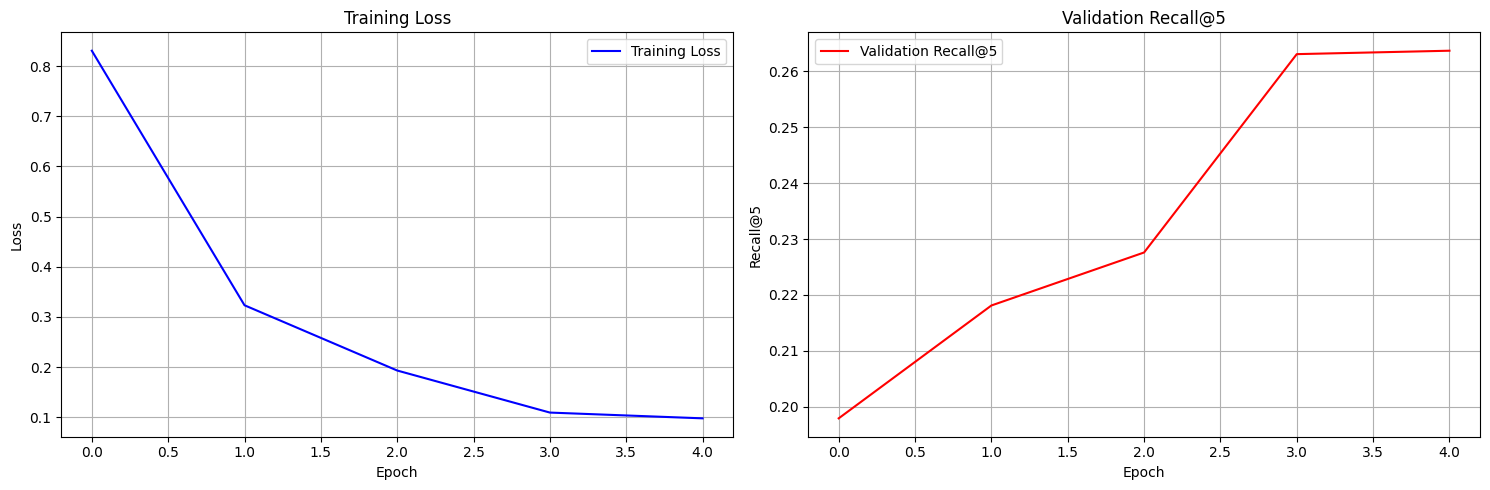

📈 Final training loss: 0.0978
📈 Final validation recall@5: 0.2637


In [33]:
# Plot training progress
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(train_losses, 'b-', label='Training Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot validation score
ax2.plot(val_scores, 'r-', label='Validation Recall@5')
ax2.set_title('Validation Recall@5')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Recall@5')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"📈 Final training loss: {train_losses[-1]:.4f}")
print(f"📈 Final validation recall@5: {val_scores[-1]:.4f}")

## 🔍 Inference and Testing

In [34]:
# Load the trained model
print("🔧 Loading trained model...")

# Find the best model file
model_files = [f for f in os.listdir(config.save_dir) if f.endswith('.pt')]
if model_files:
    best_model_file = sorted(model_files)[-1]  # Get the latest model
    model_path = os.path.join(config.save_dir, best_model_file)
    print(f"📁 Loading model from: {model_path}")

    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("✅ Trained model loaded successfully!")
else:
    print("⚠️ No trained model found. Using pretrained model.")
    model = SiglipModel.from_pretrained("google/siglip-base-patch16-224")
    model.to(device)
    model.eval()

🔧 Loading trained model...
📁 Loading model from: models/best_model_epoch_5_loss_0.0978.pt
✅ Trained model loaded successfully!


In [35]:
# Download YOLOv8 model for person detection
from ultralytics import YOLO

print("📥 Downloading YOLOv8 model...")
detector = YOLO("yolov8n.pt")
print("✅ YOLOv8 model loaded successfully!")

📥 Downloading YOLOv8 model...


100%|██████████| 6.25M/6.25M [00:00<00:00, 353MB/s]

✅ YOLOv8 model loaded successfully!



🔍 Testing sample 1:
📝 Original description: A woman with long black hair is walking. She is wearing a white sleeveless shirt or dress.

0: 640x320 1 car, 20.0ms
Speed: 2.4ms preprocess, 20.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 320)
📊 Similarity score: 0.0000


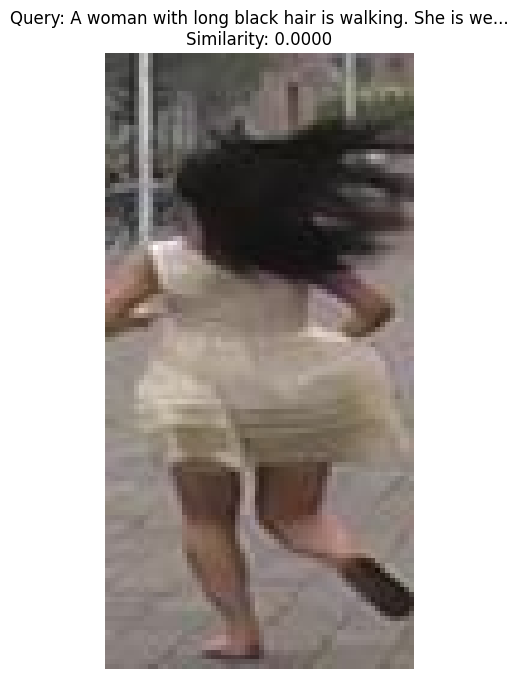


🔍 Testing sample 2:
📝 Original description: A woman with long black hair is walking. She is wearing a white sleeveless shirt or dress.

0: 640x320 1 person, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 320)
📊 Similarity score: 0.2652


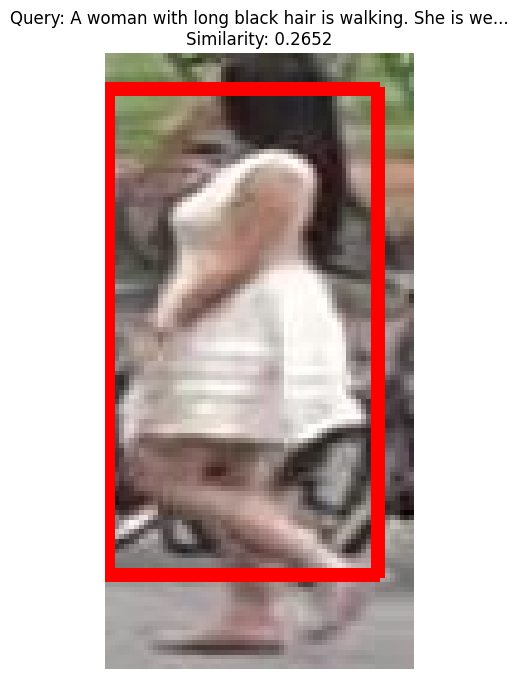


🔍 Testing sample 3:
📝 Original description: A woman with long black hair is walking. She is wearing a white sleeveless shirt or dress.

0: 640x320 1 person, 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 320)
📊 Similarity score: 0.2127


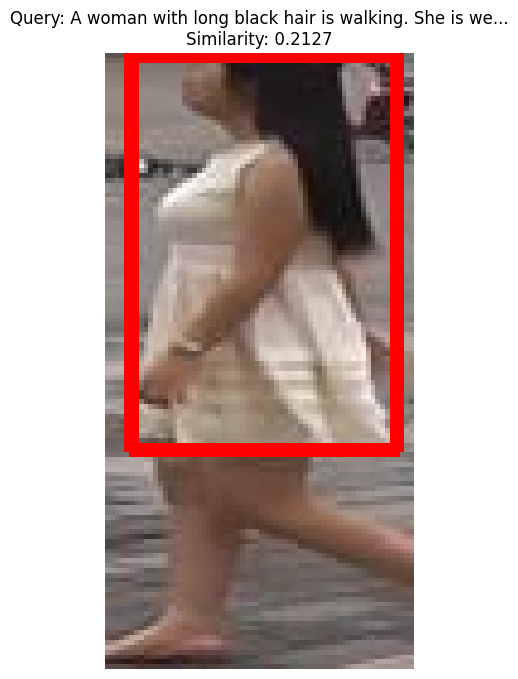

In [37]:
# Test inference on a sample from the dataset
import cv2
from PIL import Image
import numpy as np

def test_inference_on_sample(sample, text_prompt):
    """Test inference on a single sample from the dataset"""

    # Load image
    image = cv2.imread(sample.filepath)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect persons with YOLO
    results = detector(rgb_image)[0]
    boxes = results.boxes

    # Encode prompt text
    with torch.no_grad():
        text_inputs = processor(text=text_prompt, return_tensors="pt", padding=True).to(device)
        text_feat = model.get_text_features(**text_inputs)
        text_feat = torch.nn.functional.normalize(text_feat, dim=-1)

    sim = 0.0

    # Process detections
    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            cls_id = int(box.cls[0].item())

            if cls_id != 0:  # Only process persons
                continue

            # Draw default box (green)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Crop and encode with SigLIP
            crop = rgb_image[y1:y2, x1:x2]
            image_input = processor(images=crop, return_tensors="pt").to(device)

            with torch.no_grad():
                image_feat = model.get_image_features(**image_input)
                image_feat = torch.nn.functional.normalize(image_feat, dim=-1)
                sim = torch.matmul(image_feat, text_feat.T).item()

            # Label the similarity
            cv2.putText(image, f"{sim:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Highlight matched person
            if sim > 0.15:  # Threshold
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(image, "MATCH!", (x1, y1 - 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return image, sim if boxes is not None and len(boxes) > 0 else 0.0

# Test on a few samples
test_samples = query_samples.limit(3)

for i, sample in enumerate(test_samples):
    print(f"\n🔍 Testing sample {i+1}:")
    print(f"📝 Original description: {sample.description}")

    # Use the original description as the query
    result_image, similarity = test_inference_on_sample(sample, sample.description)

    print(f"📊 Similarity score: {similarity:.4f}")

    # Display result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Query: {sample.description[:50]}...\nSimilarity: {similarity:.4f}")
    plt.axis('off')
    plt.show()

🔍 Testing custom search on: /root/fiftyone/huggingface/hub/adonaivera/fiftyone-multiview-reid-attributes/data/00000001_01.jpg
📝 Query: A woman with long black hair is walking. She is wearing a white sleeveless shirt or dress.

0: 640x320 1 car, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 320)


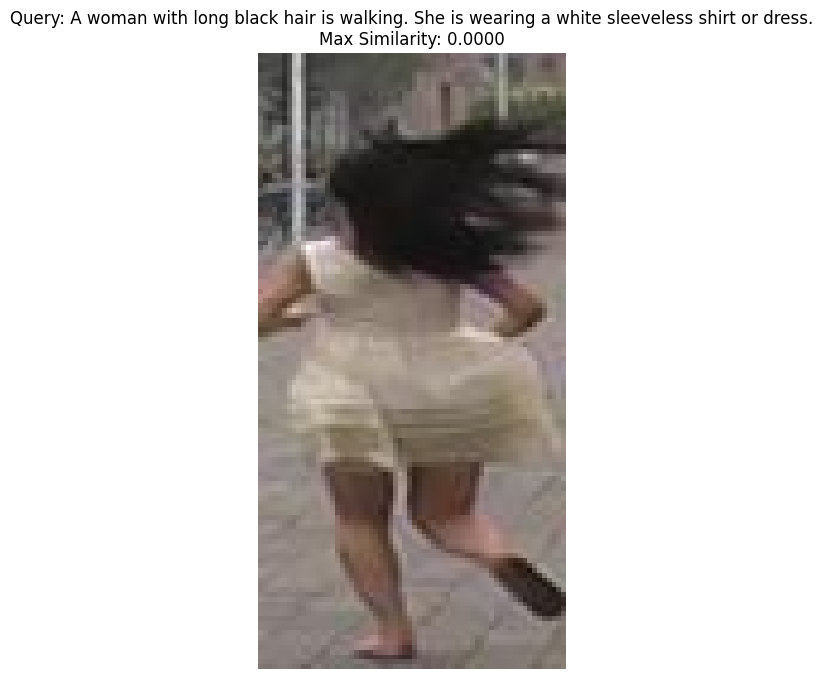

✅ Search completed! Max similarity: 0.0000


In [38]:
# Custom inference with your own text prompts
def custom_person_search(image_path, text_prompt, similarity_threshold=0.15):
    """Search for a person in an image using a text description"""

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return None, 0.0

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect persons with YOLO
    results = detector(rgb_image)[0]
    boxes = results.boxes

    # Encode prompt text
    with torch.no_grad():
        text_inputs = processor(text=text_prompt, return_tensors="pt", padding=True).to(device)
        text_feat = model.get_text_features(**text_inputs)
        text_feat = torch.nn.functional.normalize(text_feat, dim=-1)

    max_similarity = 0.0

    # Process detections
    if boxes is not None:
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
            cls_id = int(box.cls[0].item())

            if cls_id != 0:  # Only process persons
                continue

            # Draw default box (green)
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Crop and encode with SigLIP
            crop = rgb_image[y1:y2, x1:x2]
            image_input = processor(images=crop, return_tensors="pt").to(device)

            with torch.no_grad():
                image_feat = model.get_image_features(**image_input)
                image_feat = torch.nn.functional.normalize(image_feat, dim=-1)
                sim = torch.matmul(image_feat, text_feat.T).item()

            max_similarity = max(max_similarity, sim)

            # Label the similarity
            cv2.putText(image, f"{sim:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Highlight matched person
            if sim > similarity_threshold:
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(image, "MATCH!", (x1, y1 - 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return image, max_similarity

# Test with a sample from the dataset
sample = query_samples.first()
print(f"🔍 Testing custom search on: {sample.filepath}")
print(f"📝 Query: {sample.description}")

result_image, similarity = custom_person_search(sample.filepath, sample.description)

if result_image is not None:
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Query: {sample.description}\nMax Similarity: {similarity:.4f}")
    plt.axis('off')
    plt.show()

    print(f"✅ Search completed! Max similarity: {similarity:.4f}")

## 📤 Upload Your Own Images (Optional)

📤 Upload an image to test the person search system...


Saving frame2_005s.jpg to frame2_005s (1).jpg
✅ Uploaded: frame2_005s (1).jpg

🔍 Testing prompt: A woman with a handbag

0: 384x640 9 persons, 11.3ms
Speed: 3.9ms preprocess, 11.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


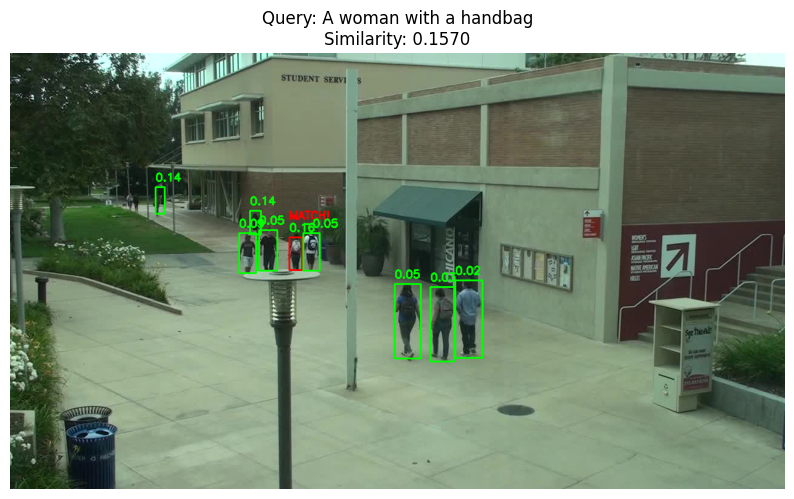

📊 Similarity score: 0.1570

🔍 Testing prompt: Someone wearing jeans and a t-shirt

0: 384x640 9 persons, 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


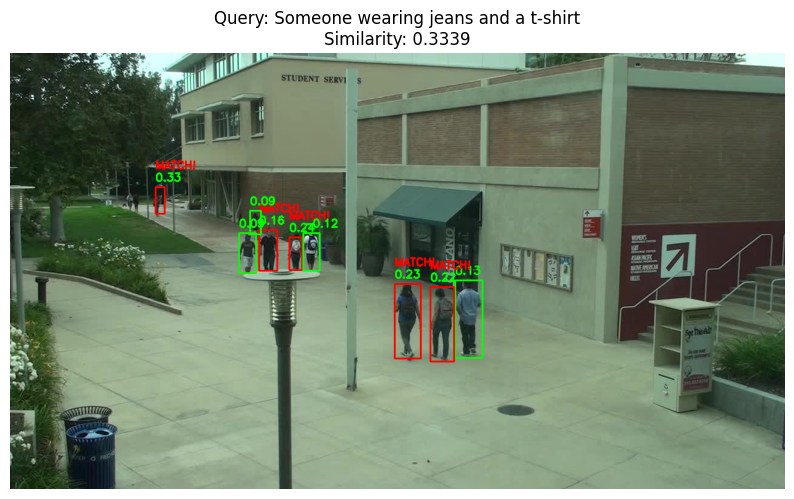

📊 Similarity score: 0.3339


In [40]:

# Upload your own image for testing
from google.colab import files
import os

print("📤 Upload an image to test the person search system...")
uploaded = files.upload()

# Get the uploaded file
uploaded_filename = list(uploaded.keys())[0]
print(f"✅ Uploaded: {uploaded_filename}")

# Test with different text prompts
test_prompts = [
    "A woman with a handbag",
    "Someone wearing jeans and a t-shirt",
]

for prompt in test_prompts:
    print(f"\n🔍 Testing prompt: {prompt}")
    result_image, similarity = custom_person_search(uploaded_filename, prompt)

    if result_image is not None:
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Query: {prompt}\nSimilarity: {similarity:.4f}")
        plt.axis('off')
        plt.show()

        print(f"📊 Similarity score: {similarity:.4f}")

## 🎉 Summary

Congratulations! You've successfully:

✅ **Cloned the repository** and set up the environment
✅ **Installed all dependencies** including PyTorch, Transformers, and YOLOv8
✅ **Downloaded the dataset** with rich semantic attributes
✅ **Trained a SigLIP model** for open-set person search
✅ **Performed inference** on images with text descriptions
✅ **Tested the system** with custom prompts and uploaded images

## 🔧 Key Features Implemented:

- **Text-based person search** using natural language descriptions
- **Multi-view ReID dataset** with 6,455 samples and rich attributes
- **YOLOv8 person detection** for automatic bounding box generation
- **Fine-tuned SigLIP model** for improved text-image similarity
- **Cosine similarity scoring** with configurable thresholds
- **Real-time inference** with optimized tracking for videos

## 🚀 Next Steps:

1. **Experiment with different text prompts** to find the best descriptions
2. **Adjust similarity thresholds** based on your use case
3. **Try video inference** using the `inference_video.py` script
4. **Fine-tune the model** on your own dataset for better performance
5. **Deploy the model** for real-world applications

## 📚 Resources:

- [Original Repository](https://github.com/AdonaiVera/openset-reid-finetune)
- [Hugging Face Model](https://huggingface.co/adonaivera/siglip-person-search-openset)
- [Dataset](https://huggingface.co/datasets/adonaivera/fiftyone-multiview-reid-attributes)
- [Gradio Demo](https://huggingface.co/spaces/adonaivera/siglip-person-finder)

Happy person searching! 🕵️‍♀️